This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fai-courses%2Fautonomous_systems_ml/HEAD?filepath=notebooks%2F6_linear_models_ridge/)

*Adapted from the [Numerical Tours of Data Sciences](https://www.numerical-tours.com/python/) examples*



# Image Deconvolution using Ridge regularization

In [1]:
from numpy import *
from numpy.fft import *
import matplotlib.pyplot as plt

We consider here the deconvolution problem: the measurement $y$ are assumed to be blurry and possibly noisy:

$$y=\Phi f_0 + w = h \star f_0 + \varepsilon,$$

where $h$ is the filter (low pass) and $\varepsilon$ some noise (here assumed to be white Gaussian).

Variational methods are powerful image processing technique to address the deconvolution problem. They aim to find a regularized solution through a convex optimization:

 $$f^\star \in \text{argmin}_f \frac{1}{2}\|y-\Phi f\|^2_2 + \lambda P(f),$$
 
where the penalty $P(f)$, commonly called a *prior energy* in image processing, 
is here to regularize the solution.

A simple and natural choice  is the (squared) L2 norm:  $P(f)=||f||_2^2$ to promote a solution which is assumed to have a bounded energy. This reduces to the ridge regression problem.

There also exist some other popular choices, e.g.
- Sobolev prior:  $P(f)=||\nabla f||_2^2$ to promote an uniformly smooth solution. This penalizes high frequencies to remove some noise (deconvolution + denoising)
- Total Variation: $P(f)=||\nabla f||_1$  to promote edges of bounded perimeter. This performs the deconvolution + denoising tasks while preserving sharpest edges.

Note also that, whatever the choice for the prior, the parameter $\lambda$ should be carefully chosen to fit the noise level.

## Image blurring

Deconvolution corresponds to removing a blur from an image. We use here a Gaussian blur.

First we load image _Ascent_ (convenient image to use for testing and demonstration which is open source conversely to Lena). 
We store it in the `y_sharp` (we denote  it as '_sharp_', because the image is clean, not degraded).

In [2]:
from scipy import misc
y_sharp = misc.ascent()
print("The size of the image is {} x {}.".format(y_sharp.shape[0],y_sharp.shape[1]))
print("The range of the pixel values is [{:.0f},{:.0f}].".format(y_sharp.min(),y_sharp.max()))
y_sharp = y_sharp.astype(float)  # cast so that the pixel values are floating point numbers

The size of the image is 512 x 512.
The range of the pixel values is [0,255].


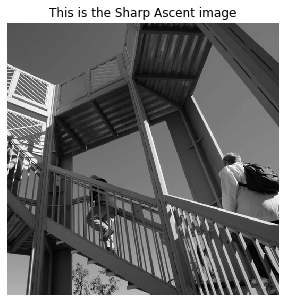

In [3]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.imshow(y_sharp, interpolation='nearest', cmap='gray')
ax.axis('off')
ax.set_title('This is the Sharp Ascent image');

We build a convolution kernel.

Bandwidth $s$ of the kernel, in pixel.

In [4]:
s = 5

Define the convolution kernel $h$.

In [5]:
n = y_sharp.shape[0] # here a square image
# we set the center of the kernel in the (0,0) pixel location.
x = concatenate( (arange(0,n/2), arange(-n/2,0)) );
[Y, X] = meshgrid(x, x)
h = exp((-X**2-Y**2)/ (2*s**2))
h = h/sum(h.flatten())

We are going to use Fourier transform to compute the convolution. Note it should be real because of the kernel symmetry:

In [6]:
hF = real(fft2(h))

Display the kernel and its transform.
We use `fftshift` to center the filter for display.

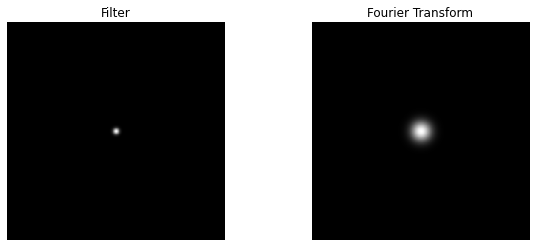

In [7]:
_, ax = plt.subplots(1, 2, figsize=(10,4))
ax[0].imshow(fftshift(h), interpolation='nearest', cmap='gray')
ax[0].axis('off')
ax[0].set_title('Filter')
ax[1].imshow(fftshift(hF), interpolation='nearest', cmap='gray')
ax[1].axis('off')
ax[1].set_title('Fourier Transform');

We use this short hand for the filtering.
Note that this is a symmetric operator.

In [8]:
Phi = lambda x,h: real(ifft2(fft2(x) * fft2(h)))

Apply the filter.

In [9]:
y_blur = Phi(y_sharp, h)

Variance $\sigma^2$ of the noise $w$.

In [46]:
sigma = 0.01 * 0

Add some noise to obtain the measurements $y = \Phi f_0 + w$.

In [47]:
y_obs = y_blur + random.randn(n,n)*sigma

Display the filtered observations.

In [48]:
from numpy.linalg import norm
def snr(y0,y):
    return 20 * log10(norm(y0) / norm(y0 - y))

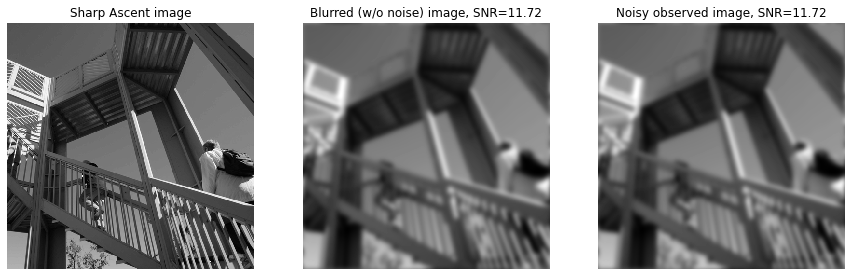

In [49]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(y_sharp, interpolation='nearest', cmap='gray')
ax[0].axis('off')
ax[0].set_title('Sharp Ascent image');
ax[1].imshow(y_blur, interpolation='nearest', cmap='gray')
ax[1].axis('off')
ax[1].set_title('Blurred (w/o noise) image, SNR={:.2f}'.format(snr(y_sharp, y_blur)))
ax[2].imshow(y_obs, interpolation='nearest', cmap='gray')
ax[2].axis('off')
ax[2].set_title('Noisy observed image, SNR={:.2f}'.format(snr(y_sharp, y_obs)));

## Deconvolution with Ridge (L2) Regularization

Deconvolution is obtained by dividing the Fourier transform of $y$
by $\hat h$.
 $$f^\star(\omega) = \frac{\hat y(\omega)}{\hat h(\omega)} = \hat f_0(\omega) + \hat \varepsilon(\omega)/{\hat h(\omega)}$$


Unfortunately this creates an explosion of the Noise.


To avoid this explosion, we consider a simple **ridge regularization**
 $$f^{\star} = \text{argmin}_f \: \|y-\Phi f\|^2 + \lambda \|f\|^2$$



Since the filtering is diagonalized over Fourier, the solution is simply
computed over the Fourier domain as:
 $$\hat f^\star(\omega) = \frac{\hat y(\omega) \hat h(\omega)}{ \|\hat h(\omega)\|^2 + \lambda }$$



Useful for later: Fourier transform of the observations.

In [50]:
yF = fft2(y_obs)

Select a value for the regularization parameter.

In [63]:
Lambda = 1e-31

Perform the inversion.

In [64]:
y_ridge = real(ifft2(yF * hF / (abs(hF)**2 + Lambda)))

Display.

In [65]:
snr(y_sharp, y_ridge)

19.716605317267636

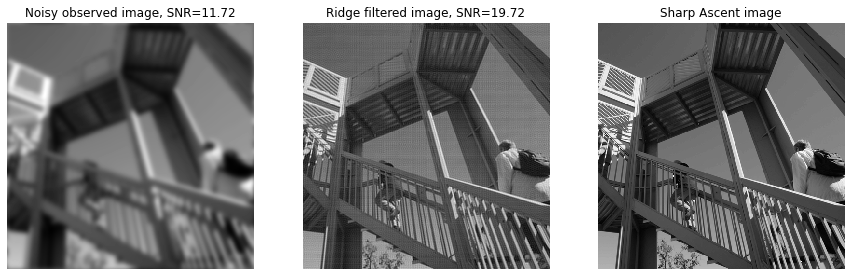

In [66]:
fig, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].imshow(y_obs, interpolation='nearest', cmap='gray')
ax[0].axis('off')
ax[0].set_title('Noisy observed image, SNR={:.2f}'.format(snr(y_sharp, y_obs)));
ax[1].imshow(y_ridge, interpolation='nearest', cmap='gray')
ax[1].axis('off')
ax[1].set_title('Ridge filtered image, SNR={:.2f}'.format(snr(y_sharp, y_ridge)));
ax[2].imshow(y_sharp, interpolation='nearest', cmap='gray')
ax[2].axis('off')
ax[2].set_title('Sharp Ascent image');


**Exercise:**
- What happens when there is no regularization (`Lambda=0`)?
- Is it the same even when the noise variance `sigma` is set to zero?

Plot the SNR as a function of $\lambda$.
Note that it is better to use a log-scale for the dynamic of the $\lambda$'s

Also display the  MSE to show the bias/variance tradeoff (remember that MSE = variance + bias^2)

In [61]:
lambdas = logspace(-32,-0,50) # log scale from 10^{-10} to 10^{-2}
snrs = ndarray(lambdas.shape)
biases = ndarray(lambdas.shape)
variances = ndarray(lambdas.shape)
mses = ndarray(lambdas.shape)
for i,l in enumerate(lambdas):
    tmp = real(ifft2(yF * hF / (abs(hF)**2 + l)))
    snrs[i] = snr(y_sharp, tmp)
    biases[i] = mean(y_sharp - tmp)**2 # squared bias 
    variances[i] =  var(y_sharp - tmp)
    mses[i] = mean( (y_sharp - tmp)**2 ) # squared bias + variance

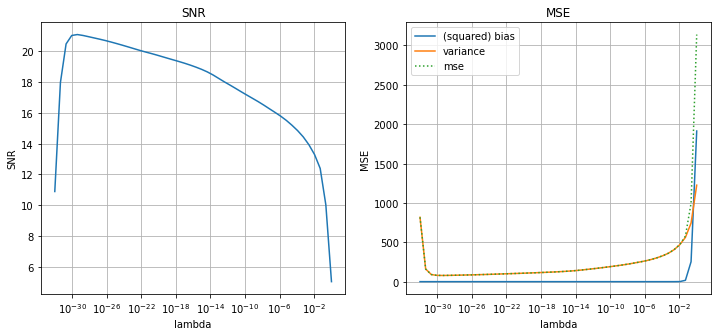

In [62]:
# Display
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].semilogx(lambdas,snrs)
ax[0].set_xlabel('lambda')
ax[0].set_ylabel('SNR')
ax[0].set_title('SNR')
ax[0].grid('On')
ax[1].semilogx(lambdas, biases, label = '(squared) bias')
ax[1].semilogx(lambdas, variances, label='variance')
ax[1].plot(lambdas, mses, ':', label='mse',)          
ax[1].set_xlabel('lambda')
ax[1].set_ylabel('MSE')
ax[1].set_title('MSE')
ax[1].legend()
ax[1].grid('On')

**Exercise:**
- Comment the shape of the SNR and MSE curves: what are the problems on each tail? Does it worth to introduce a small bias?
- Find/Display/Comment the optimal solution,
- *Optional*: What happens for larger noise variance $\sigma$?
- *Optional*: How can we proceed to efficiently compute the regularized solution when the Fourier approach is no longer suitable (for example when the blurring operation is not spatially invariant, or when the penalty is not quadratic as for the total variation prior energy)?